In [1]:
import json
import pandas as pd
import re
import gensim

from tqdm import tqdm
from gensim.models import word2vec

import numpy as np
import copy

# 1. Загружаем и обрабатываем словарь RuSentiFrames 

In [2]:
!wget https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json

--2021-05-24 12:51:48--  https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 674938 (659K) [text/plain]
Saving to: ‘collection.json’

collection.json     100%[===================>] 659.12K  --.-KB/s    in 0.1s    

2021-05-24 12:51:48 (5.97 MB/s) - ‘collection.json’ saved [674938/674938]



In [3]:
f = open('collection.json', 'r')
json_string = f.read()
f.close()

data = json.loads(json_string)

In [4]:
cols = ['predicate', 'role_a0', 'author_a0', 'value_author_a0']

row_l_list = []
row_b_list = []
main_verbs_list = []

for predicate in data:
    frames = {}
    
    if 'a0' in data[predicate]['roles']:
        frames['role_a0'] = data[predicate]['roles']['a0']  #считываем роль a0 - наиболее агентивный участник
    else:
        frames['role_a0'] = None

    if 'polarity' in data[predicate]['frames']:   #записываем все известные отношения между a0 и a1 участниками в словарь
        for attitude in data[predicate]['frames']['polarity']:
            if attitude[0] == 'author' and attitude[1] == 'a0':
                frames['author_a0'] = attitude[2]
                frames['value_author_a0'] = attitude[3]
    
    for col in cols:
        if col not in frames:
          if col == 'value_author_a0':
            frames[col] = '0'
          else:
            frames[col] = 'neutr'   #если чего-либо из выше перечисленного нет, то записываем neutr

    
    exact_frame = copy.deepcopy(frames) #дипкопи, потому что словарь меняется
    exact_frame['predicate'] = data[predicate]['title'][0]
    row_l_list.append(exact_frame) #добавляем предикат из title в список строк маленького датафрейма
    
    for el in data[predicate]['title'] + data[predicate]['variants']:  #добавляем предикаты из title и variants в список строк большого датафрейма
        if len(el.split()) == 1: #хотим брать только глаголы из одного слова для простоты поиска в дальнейшем
          exact_frame = copy.deepcopy(frames)
          exact_frame['predicate'] = el
          if exact_frame not in row_b_list:
            main_verbs_list.append(data[predicate]['title'][0])
            row_b_list.append(exact_frame)

df_little = pd.DataFrame(row_l_list, columns=cols) #база с основными предикатами
df_big = pd.DataFrame(row_b_list, columns=cols) #база с основными предикатами и их вариантами

In [5]:
print(len(df_little), len(df_big))  # длины маленького и большого датафрейма

311 4430


In [6]:
df_little.head()

,predicate,role_a0,author_a0,value_author_a0
0,надеяться,"тот, кто надеется",neutr,0
1,довериться,"тот, кто доверяется",neutr,0
2,умереть,умерший,neutr,0
3,дохнуть (умирать),умерший,neg,0.7
4,выиграть,победитель,neutr,0


In [7]:
df_big.head()

,predicate,role_a0,author_a0,value_author_a0
0,надеяться,"тот, кто надеется",neutr,0
1,ждать,"тот, кто надеется",neutr,0
2,опереться,"тот, кто надеется",neutr,0
3,опираться,"тот, кто надеется",neutr,0
4,чаять,"тот, кто надеется",neutr,0


In [8]:
#df_big.to_csv('df_big.csv')
#df_little.to_csv('df_little.csv')

# 2. Выделяем контексты предикатов из корпусов


### 2.1 Корпус Ru_syntagrus

### 2.1.1 скачиваем и парсим данные


In [9]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu

--2021-05-24 12:51:49--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81039282 (77M) [text/plain]
Saving to: ‘ru_syntagrus-ud-train.conllu’

ru_syntagrus-ud-tra 100%[===================>]  77.28M  50.1MB/s    in 1.5s    

2021-05-24 12:51:59 (50.1 MB/s) - ‘ru_syntagrus-ud-train.conllu’ saved [81039282/81039282]



In [10]:
synt = open('ru_syntagrus-ud-train.conllu', 'r')

s = synt.read()
synt.close()

In [11]:
!pip install conllu

In [12]:
from conllu import parse_tree
from conllu import parse

In [13]:
sentences = parse(s)
trees = parse_tree(s)

In [14]:
sentences[1][1]

{'deprel': 'amod',
 'deps': [('amod', 3)],
 'feats': {'Case': 'Gen', 'Degree': 'Pos', 'Gender': 'Neut', 'Number': 'Sing'},
 'form': 'областного',
 'head': 3,
 'id': 2,
 'lemma': 'областной',
 'misc': None,
 'upos': 'ADJ',
 'xpos': None}

In [15]:
len(sentences)

48814

### 2.1.2 Сделаем датафрейм с названиями документов и самими текстами.

In [16]:
doc_names = []
doc_texts = []
names_used  = []
count_sent = 0

for sentence in tqdm(sentences):
  if sentence.metadata['sent_id'].split('_')[0] in names_used:
    doc_texts[-1] += ' ' + sentence.metadata['text']
  else:
    doc_texts.append(sentence.metadata['text'])
    doc_names.append(sentence.metadata['sent_id'].split('_')[0])
    names_used.append(sentence.metadata['sent_id'].split('_')[0])

100%|██████████| 48814/48814 [00:01<00:00, 45846.78it/s] 


In [17]:
df_docs = pd.DataFrame()
df_docs['doc_name'] = doc_names
df_docs['doc_text'] = doc_texts

In [18]:
#df_docs.to_csv('df_docs_synt.csv')

### 2.1.3 Выделяем контексты для глаголов


In [19]:
verb_neg_a0 = [verb for verb in df_little.predicate.values if len(verb.split()) == 1 and df_little[df_little['predicate'] == verb].author_a0.values[0] == 'neg']
verb_pos_a0 = [verb for verb in df_little.predicate.values if len(verb.split()) == 1 and df_little[df_little['predicate'] == verb].author_a0.values[0] == 'pos']
verb_neutr_a0 = [verb for verb in df_little.predicate.values if len(verb.split()) == 1 and df_little[df_little['predicate'] == verb].author_a0.values[0] == 'neutr']
print('Длина списка позитивных глаголов: ', len(verb_pos_a0))
print('Длина списка негативных глаголов: ', len(verb_neg_a0))
print('Длина списка нейтральных глаголов: ', len(verb_neutr_a0))

Длина списка позитивных глаголов:  12
Длина списка негативных глаголов:  68
Длина списка нейтральных глаголов:  200


In [20]:
verb_pos_a0

['карать',
 'предотвратить',
 'обезвредить',
 'вразумить',
 'воодушевить',
 'ладить',
 'изобличить',
 'подобать',
 'развить',
 'развиваться',
 'постичь',
 'почить']

In [21]:
def extract_tree(root, a0_word, a0_lemma, pos):  #функция для выделения группы
  if a0_lemma == '':
    a0_lemma = root.token['lemma']
    a0_word = root.token['form']
    pos = str(root.token['id'])
  else:
    a0_lemma += ' ' + root.token['lemma']
    a0_word += ' ' + root.token['form']
    pos += ' ' + str(root.token['id'])
  for child in root.children:
    a0_word, a0_lemma, pos = extract_tree(child, a0_word, a0_lemma, pos)
    
  return a0_word, a0_lemma, pos

In [22]:
def search_tree(root, lemma): #поиск в дереве конкретного токена
  if root.token['lemma'] == lemma:
    return root
  else:
    for child in root.children:
      answ = search_tree(child, lemma)
      if answ is not None:
        return answ

In [23]:
def get_contexts(verb_list):
  lemmas = []
  a0 = []
  a0_l = []
  sent_ids = []
  sents = []
  docs = []
  single_words = []
  position_s_word = []
  positions = []


  for i, sentence in enumerate(sentences):
    for verb in verb_list:
      if verb == None:
        continue
      for word in sentence:
        if str(word['lemma']) == verb:  #если слово совпадает с текущим глаголом и его форма финитная (инфинитивы непоказательны)
          if 'VerbForm' in word['feats']: 
            if word['feats']['VerbForm'] == 'Fin':
              root = trees[i]
              a0_word = ''
              a0_lemma = ''
              s_word = ''
              position = ''
              pos_s = ''
              verb_token = search_tree(root, verb)  #нашли в дереве токен нашего глагола
              for child in verb_token.children:  #среди зависимых ищем субъект
                if child.token['deprel'] == 'nsubj' or child.token['deprel'] == 'csubj':
                  s_word = child.token['form']
                  pos_s = str(child.token['id'])
                  a0_word, a0_lemma, position = extract_tree(child, a0_word, a0_lemma, position) #выделяем субъектую группу и дальше можно не идти
              
              if a0_word == 'который':   #если это слово который, то берем его вершину
                head_word_n = word['head']
                head_word = sentence.filter(id=head_word_n)
                a0_word = head_word[0]['form']
                a0_lemma = head_word[0]['lemma']
                s_word = head_word[0]['form']
                pos_s = str(head_word[0]['id'])
                position = str(head_word[0]['id'])
            
              if a0_word == '': #учитываем случай сочинения, берем вершину второго глагола
                head_word_n = word['head']
                head_word = sentence.filter(id=head_word_n)
                if len(head_word) > 0:
                  if head_word[0]['upos'] == 'VERB':
                    head_token = search_tree(root,  head_word[0]['lemma'])
                    for child in head_token.children:
                      if child.token['deprel'] == 'nsubj':
                        a0_word = child.token['form']
                        a0_lemma = child.token['lemma']
                        s_word = child.token['form']
                        pos_s = str(child.token['id'])
                        position = str(child.token['id'])
              

              a0.append(a0_word)
              a0_l.append(a0_lemma)
              single_words.append(s_word)
              lemmas.append(verb)
              sent_ids.append(i)
              sents.append(sentence.metadata['text'])
              docs.append(sentence.metadata['sent_id'])
              positions.append(position)
              position_s_word.append(pos_s)
              

  df = pd.DataFrame()
  df['verb'] = lemmas
  df['a0'] = a0
  df['positions'] = positions
  df['a0_single_word'] = single_words
  df['position_single'] = position_s_word
  df['sentence'] = sents
  df['doc'] = docs

  return df

In [24]:
df_pos_a0 = get_contexts(verb_pos_a0)

In [25]:
df_neg_a0 = get_contexts(verb_neg_a0)

In [26]:
df_neutr_a0 = get_contexts(verb_neutr_a0)

In [27]:
print('Длина списка позитивных глаголов: ', len(df_pos_a0))
print('Длина списка негативных глаголов: ', len(df_neg_a0))
print('Длина списка нейтральных глаголов: ', len(df_neutr_a0))


Длина списка позитивных глаголов:  79
Длина списка негативных глаголов:  239
Длина списка нейтральных глаголов:  4949


### 2.2 Добавим контексты для положительных предикатов

In [28]:
df_positive = pd.read_csv('df_positive.csv')

In [29]:
 df_positive['verb'].unique().tolist()

['обезвредить',
 'вразумить',
 'ладить',
 'подобать',
 'карать',
 'предотвратить',
 'воодушевить',
 'изобличить',
 'развить',
 'развиваться',
 'постичь',
 'почить']

In [30]:
! pip install natasha


     |████████████████████████████████| 34.4MB 87kB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26102 sha256=f3631e89ffea07d8971f22c0684c54b138cfeba81501703e3f88dc7ec30d389b
  Stored in directory: /root/.cache/pip/wheels/f3/f2/66/e9c30d3e9499e65ea2fa0d07c002e64de63bd0adaa49c445bf
Successfully built intervaltree
  Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [31]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)


In [32]:
emb = NewsEmbedding()
syntax_parser = NewsSyntaxParser(emb)
segmenter = Segmenter()

In [33]:
def extract_deps(word, sent, a0_word, a0_lemma, a0_p):
  if 'который' in a0_lemma.split():
    return a0_word, a0_lemma, a0_p
  if a0_lemma == '':
    a0_lemma = word.lemma
    a0_word = word.text
    a0_p = word.id.split('_')[1]
  else:
    a0_lemma += ' ' + word.lemma
    a0_word += ' ' + word.text
    a0_p += ' ' + word.id.split('_')[1]
  
  for el in sent:
    if el.head_id == word.id:
      a0_word, a0_lemma, a0_p = extract_deps(el, sent, a0_word, a0_lemma, a0_p)

  return a0_word, a0_lemma, a0_p

In [34]:
lemmas = []
a0 = []
a0_l = []
sent_ids = []
sents = []
a0_pos = []
a0_single_pos = []
a0_single = []
c = 0
for sentence in df_positive['sentence'].values:
  c += 1
  doc = Doc(sentence)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  doc.parse_syntax(syntax_parser)

  
  for token in doc.tokens:
    for verb in df_positive['verb'].unique().tolist():
      if token.lemma == verb:
        if 'VerbForm' in token.feats:
          if token.feats['VerbForm'] == 'Fin':
            verb_id = token.id
            for i, word in enumerate(doc.tokens):
              a0_word = ''
              a0_lemma  = ''
              a0_p = ''
              a0_s = ''
              a0_s_p = ''

              if word.head_id == verb_id and word.rel == 'nsubj' and word.pos != 'NUM':
                try:
                  a0_s = word.text
                  a0_s_p = str(i + 1)
                  a0_word, a0_lemma, a0_p = extract_deps(word, doc.tokens, a0_word, a0_lemma, a0_p)

                  if a0_lemma == 'который':
                    for j, another_word in enumerate(doc.tokens):
                      if another_word.id == token.head_id:
                        a0_s_p = str(j+1)
                        a0_s = another_word.text
                        a0_word, a0_lemma, a0_p = extract_deps(another_word, doc.tokens, a0_word='', a0_lemma = '', a0_p = '') 
                        break
                  a0_p = [pos for pos, word in zip(a0_p.split(), a0_lemma.split()) if word not in [',', '―', 'который', verb]]
                  a0_word = [word for word, lemma in zip(a0_word.split(), a0_lemma.split()) if lemma not in [',', '―', verb, 'который']]

                  a0_p = ' '.join(a0_p)
                  a0_word = ' '.join(a0_word)

                  a0.append(a0_word)
                  a0_pos.append(a0_p)
                  lemmas.append(verb)  
                  sents.append(doc.text)
                  a0_single.append(a0_s)
                  a0_single_pos.append(a0_s_p)
          
                except RecursionError:
                  print(doc.text, word)
                  continue    
                break

  

Наконец смертельная тоска, рожденная безумной надеждой, воодушевила его. DocToken(start=20, stop=25, text='тоска', id='1_3', head_id='1_9', rel='nsubj', pos='NOUN', feats=<Inan,Nom,Fem,Sing>, lemma='тоска')


In [35]:
df_pos_a0 = pd.DataFrame()
df_pos_a0['verb'] = lemmas
df_pos_a0['a0'] = a0
df_pos_a0['positions'] = a0_pos
df_pos_a0['a0_single_word'] = a0_single
df_pos_a0['position_single'] = a0_single_pos
df_pos_a0['sentence'] = sents

In [36]:
df_pos_a0.verb.value_counts()

развиваться      20
обезвредить      17
развить          16
предотвратить    15
ладить           13
карать           13
вразумить        10
воодушевить      10
изобличить        8
почить            6
подобать          2
постичь           1
Name: verb, dtype: int64

# 3. Создаем эмбеддинги для аргументов и анализируем полярность




## 3.1 Скачиваем словарь RuSentiLex для формирования сидов  - НЕ НУЖНО

In [37]:
!wget https://raw.githubusercontent.com/eszakharova/TextPopularityEstimation/master/preprocessing/rusentilex_2017.txt

--2021-05-24 12:54:36--  https://raw.githubusercontent.com/eszakharova/TextPopularityEstimation/master/preprocessing/rusentilex_2017.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1329239 (1.3M) [text/plain]
Saving to: ‘rusentilex_2017.txt’

rusentilex_2017.txt 100%[===================>]   1.27M  7.62MB/s    in 0.2s    

2021-05-24 12:54:36 (7.62 MB/s) - ‘rusentilex_2017.txt’ saved [1329239/1329239]



In [38]:
fs = open('rusentilex_2017.txt', 'r')
pre_sent_arr = [line.split(', ') for line in fs.readlines() if not line.startswith('!')]
fs.close()
sent_words = []
sent_scores = []
sent_lemmas = []
for i in range(len(pre_sent_arr)):
  if pre_sent_arr[i][3] in ['positive', 'negative', 'neutral'] and len(pre_sent_arr[i]) == 5:
    sent_words.append(pre_sent_arr[i][0])
    sent_lemmas.append(pre_sent_arr[i][2])
    sent_scores.append(pre_sent_arr[i][3])

In [39]:
dy = pd.DataFrame()
dy['word'] = [word for i, word in enumerate(sent_words)]
dy['lemma'] = [word for word in sent_lemmas]
dy['label'] = [score for i, score in enumerate(sent_scores)]
dy['label'].value_counts()

negative    8462
positive    2880
neutral      503
Name: label, dtype: int64

## 3.2 Эмбеддинги Deeppavlov bert_embedder

### Устанавливаем библиотеку и скачиваем модель

In [ ]:
!pip install deeppavlov

In [ ]:
!python -m deeppavlov install bert_embedder.json


In [42]:
!python -m deeppavlov download  bert_embedder.json


2021-05-24 12:57:46.519 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/bert/multi_cased_L-12_H-768_A-12_pt.tar.gz?config=bert_embedder to /root/.deeppavlov/downloads/multi_cased_L-12_H-768_A-12_pt.tar.gz
100% 663M/663M [03:34<00:00, 3.09MB/s]
2021-05-24 13:01:22.914 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /root/.deeppavlov/downloads/multi_cased_L-12_H-768_A-12_pt.tar.gz archive into /root/.deeppavlov/downloads/bert_models


In [43]:
from deeppavlov import build_model, configs

bert_embed = build_model(configs.embedder.bert_embedder)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


In [44]:
def get_embed(word):
  tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = bert_embed([word])
  return np.average(token_embs[0], axis=0)

### Функция для подсчета схожести

In [45]:
from scipy.spatial.distance import cosine

def cossim(vec1, vec2):
   return 1 - cosine(vec1, vec2)

### Создаем семантическую ось

In [46]:
def get_pole_centroid_bert(seed):
  tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = bert_embed(seed)
  return np.average(token_embs, axis=0)

In [47]:
negative_seed  = dy[dy['label'] == 'negative'].sample(20).lemma.values.tolist()
positive_seed  = dy[dy['label'] == 'positive'].sample(20).lemma.values.tolist()

In [48]:
positive_seed = ['хороший', 'милый', 'отличный', 'удача', 'приятно', 'радовать', 'идеал', 'удивительный', 'счастье', 'спасать', 'обожать']
negative_seed = ['плохой', 'ужасный', 'бедный','грубость','отвратительно', 'ненавидеть', 'худший', 'страх','вранье', 'умирать','разочаровать']

In [49]:
axis = get_pole_centroid_bert(positive_seed) - get_pole_centroid_bert(negative_seed)

In [50]:
cossim(axis, get_embed('веселый человек радуется'))

0.01917908526957035

In [51]:
cossim(axis, get_embed('грустный человек печалится'))

-0.08913856744766235

### Выберем глаголы для анализа

In [52]:
pos_verbs_for_analysis = [verb for verb in df_pos_a0.verb.unique() if verb in  df_pos_a0[df_pos_a0['a0'] != ''].verb.value_counts() and df_pos_a0[df_pos_a0['a0'] != ''].verb.value_counts()[verb] > 5]
neg_verbs_for_analysis = [verb for verb in df_neg_a0.verb.unique() if verb in  df_neg_a0[df_neg_a0['a0'] != ''].verb.value_counts() and df_neg_a0[df_neg_a0['a0'] != ''].verb.value_counts()[verb] > 5]
#берем те глаголы, у которых больше 6 контекстов

In [53]:
import random
neutr_verbs = [verb for verb in df_neutr_a0.verb.unique() if verb in  df_neutr_a0[df_neutr_a0['a0'] != ''].verb.value_counts() and df_neutr_a0[df_neutr_a0['a0'] != ''].verb.value_counts()[verb] > 6]
neutr_verbs_for_analysis = random.sample(neutr_verbs, k = 15)

In [54]:
print('Длина списка позитивных глаголов, которые использовались для анализа: ', len(pos_verbs_for_analysis))
print('Длина списка негативных глаголов, которые использовались для анализа: ', len(neg_verbs_for_analysis))
print('Длина списка нейтральных глаголов, которые использовались для анализа: ', len(neutr_verbs_for_analysis))

Длина списка позитивных глаголов, которые использовались для анализа:  10
Длина списка негативных глаголов, которые использовались для анализа:  11
Длина списка нейтральных глаголов, которые использовались для анализа:  15


In [55]:
neutr_verbs_for_analysis = ['уничтожить',
 'объяснить',
 'хотеть',
 'убедить',
 'считать',
 'дарить',
 'создать',
 'помнить',
 'обвинить',
 'благодарить',
 'умереть',
 'любить',
 'бросить',
 'спасти',
 'улыбаться']


### Создадим дф для сохранения результатов

In [60]:
df_rez_exp1 = pd.DataFrame()
df_rez_exp2 = pd.DataFrame()

### 3.2.1 по одному слову, контекст = предложение

In [56]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
def preproc(text):
  #text_list = text.split()
  #for i in range(len(text_list)):
    #text_list[i] = text_list[i].strip('!.,?:;\'\"')
  #text = ' '.join(text_list)
  text = word_tokenize(text, language='russian')
  text = ' '.join(text)
  return text

In [57]:
def get_subj_embed_single(sentences, positions):
  
  for i, sentence in enumerate(sentences):
    tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = bert_embed([sentence])
    if i == 0:
      mean_subj_embed = np.zeros_like(token_embs[0][0])
      sum_subj_embed = np.zeros_like(token_embs[0][0])
    pos = int(positions[i]) - 1
    mean_subj_embed += token_embs[0][pos]
    sum_subj_embed += token_embs[0][pos]

  return mean_subj_embed/len(token_embs), sum_subj_embed


In [58]:
def get_mean_sum(verb_list, df):
  mean_embs = []   #считаем сумму и среднее всех эмбеддингов субъектов (одно слово по предложению) для глаголов
  sum_embs = []
  for verb in verb_list:  

    subj_list = df[df['verb'] == verb][df['a0'] != ''].a0_single_word.values.tolist()
    sentences = df[df['verb'] == verb][df['a0'] != ''].sentence.values.tolist()
    positions = df[df['verb'] == verb][df['a0'] != ''].position_single.values.tolist()

    if len(subj_list) > 50:
      m, s = get_subj_embed_single(sentences[:50], positions[:50])
    else:
      m, s = get_subj_embed_single(sentences[:50], positions[:50])

    mean_embs.append(m)
    sum_embs.append(s)

  return mean_embs, sum_embs 


In [125]:
neg_mean_embs, neg_sum_embs = get_mean_sum(neg_verbs_for_analysis, df_neg_a0) 
avg = 0
rezs = []
labels = []
for i, mean in enumerate(neg_mean_embs):
  rezs.append(cossim(axis, mean))
  labels.append('neg')
  print(neg_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neg_mean_embs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


стрелять -0.0009422995499335229
подвести -0.017574552446603775
надоесть -0.02901364117860794
грозить -0.047074250876903534
нарушить -0.05860564112663269
провоцировать 0.0012247080449014902
игнорировать -0.010903555899858475
мучить -0.0006883962778374553
обидеть -0.016112325713038445
убить 0.013129172846674919
захватить 0.01868445985019207
Среднее: -0.013443302029786124


In [126]:
neutr_mean_embs, neutr_sum_embs = get_mean_sum(neutr_verbs_for_analysis, df_neutr_a0)
avg = 0
for i, mean in enumerate(neutr_mean_embs):
  rezs.append(cossim(axis, mean))
  labels.append('neutr')
  print(neutr_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neutr_mean_embs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


уничтожить -0.04396979510784149
объяснить -0.005017929244786501
хотеть 0.03467436507344246
убедить -0.002195584587752819
считать -0.042633745819330215
дарить 0.02451673522591591
создать 0.0439741350710392
помнить -0.011032616719603539
обвинить -0.00718452874571085
благодарить -0.020726682618260384
умереть -0.019652051851153374
любить 0.02548207901418209
бросить 0.013671370223164558
спасти 0.03524821996688843
улыбаться 0.028263965621590614
Среднее: 0.003561195700118939


In [127]:
pos_mean_embs, pos_sum_embs = get_mean_sum(pos_verbs_for_analysis, df_pos_a0)  
avg = 0
for i, mean in enumerate(pos_mean_embs):
  rezs.append(cossim(axis, mean))
  labels.append('pos')
  print(pos_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(pos_mean_embs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


обезвредить 0.015969105064868927
вразумить 0.05537644028663635
ладить 0.02491629123687744
карать -0.04725298658013344
предотвратить 0.02469639480113983
воодушевить 0.07817308604717255
изобличить 0.031750425696372986
развить -0.02296833135187626
развиваться 0.003858760232105851
почить -0.03693685308098793
Среднее: 0.01275823323521763


In [128]:
df_rez_exp1['verb'] = neg_verbs_for_analysis + neutr_verbs_for_analysis + pos_verbs_for_analysis
df_rez_exp1['value'] = rezs
df_rez_exp1['label'] = labels

In [129]:
df_rez_exp1.head()

,verb,value,label
0,стрелять,-0.000942,neg
1,подвести,-0.017575,neg
2,надоесть,-0.029014,neg
3,грозить,-0.047074,neg
4,нарушить,-0.058606,neg


### 3.2.2 по подлежащной группе, контекст - предложение

In [69]:
def get_subj_embed_seq(sentences, positions):
  for i, sentence in enumerate(sentences):
    tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = bert_embed([sentence])
    if i == 0:
      mean_subj_embed = np.zeros_like(token_embs[0][0])
      sum_subj_embed = np.zeros_like(token_embs[0][0])
    s_g = np.zeros_like(token_embs[0][0])
    m_g = np.zeros_like(token_embs[0][0])

    for pos in positions[i].split():
      p = int(pos) - 1
      s_g += token_embs[0][p]
      m_g += token_embs[0][p]
    m = m_g/len(positions[i].split())
    mean_subj_embed += m
    sum_subj_embed += m


  return mean_subj_embed/len(token_embs), sum_subj_embed

In [70]:
def get_mean_sum_seq(verb_list, df):
  mean_embs = []   #считаем сумму и среднее всех эмбеддингов субъектов (одно слово по предложению) для глаголов
  sum_embs = []
  for verb in verb_list:  

    subj_list = df[df['verb'] == verb][df['a0'] != ''].a0.values.tolist()
    sentences = df[df['verb'] == verb][df['a0'] != ''].sentence.values.tolist()
    positions = df[df['verb'] == verb][df['a0'] != ''].positions.values.tolist()

    if len(subj_list) > 50:
      m, s = get_subj_embed_seq(sentences[:50], positions[:50])
    else:
      m, s = get_subj_embed_seq(sentences[:50], positions[:50])

    mean_embs.append(m)
    sum_embs.append(s)

  return mean_embs, sum_embs 

In [130]:
neg_mean_embs_seq, neg_sum_embs_seq = get_mean_sum_seq(neg_verbs_for_analysis, df_neg_a0)
avg = 0
rezs = []
labels = []
for i, mean in enumerate(neg_mean_embs_seq):
  rezs.append(cossim(axis, mean))
  labels.append('neg')
  print(neg_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neg_mean_embs_seq))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


стрелять 0.004094315227121115
подвести -0.013226008042693138
надоесть -0.01961575634777546
грозить -0.049616292119026184
нарушить -0.03640352189540863
провоцировать -0.007824237458407879
игнорировать -0.016479579731822014
мучить 0.0021475371904671192
обидеть -0.033595118671655655
убить 0.016857078298926353
захватить 0.024949630722403526
Среднее: -0.011701086620715532


In [131]:
neutr_mean_embs_seq, neutr_sum_embs_seq = get_mean_sum_seq(neutr_verbs_for_analysis, df_neutr_a0)  
avg = 0
for i, mean in enumerate(neutr_mean_embs_seq):
  rezs.append(cossim(axis, mean))
  labels.append('neutr')
  print(neutr_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neutr_mean_embs_seq))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


уничтожить -0.037805382162332535
объяснить -0.0089587876573205
хотеть 0.03057333081960678
убедить 0.013437282294034958
считать -0.03715959191322327
дарить 0.01131789293140173
создать 0.03867243975400925
помнить -0.009313627146184444
обвинить -0.03977449983358383
благодарить -0.037823956459760666
умереть -0.02952520176768303
любить 0.017286624759435654
бросить 0.010846043936908245
спасти 0.028622929006814957
улыбаться 0.02425789274275303
Среднее: -0.0016897740463415782


In [132]:
pos_mean_embs_seq, pos_sum_embs_seq = get_mean_sum_seq(pos_verbs_for_analysis, df_pos_a0)   
avg = 0
for i, mean in enumerate(pos_mean_embs_seq):
  rezs.append(cossim(axis, mean))
  labels.append('pos')
  print(pos_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(pos_mean_embs_seq))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


обезвредить 0.01651657558977604
вразумить 0.04910176619887352
ладить 0.013290534727275372
карать -0.018966026604175568
предотвратить 0.01885116659104824
воодушевить 0.04186328127980232
изобличить 0.04577798396348953
развить -0.0008023674599826336
развиваться 0.0057938797399401665
почить -0.020567525178194046
Среднее: 0.015085926884785295


In [133]:
df_rez_exp2['verb'] = neg_verbs_for_analysis + neutr_verbs_for_analysis + pos_verbs_for_analysis
df_rez_exp2['value'] = rezs
df_rez_exp2['label'] = labels

### 3.2.3 по одному слову, контекст - весь документ

In [75]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def sent_tokenization(text, doc, pos):
  n_sent = -1
  sents = sent_tokenize(doc)
  for i, sent in enumerate(sents):
    if len(sent.split()) > 6 and len(text.split()) > 6:
      if sent.split()[:7] == text.split()[:7]:
        if n_sent != -1:
          print(sent, text)
          n_sent = i
        else:
          n_sent = i
    elif sent == text:
      n_sent = i
  
  if n_sent == -1:
    w_sent = nltk.word_tokenize(text)
    doc_toks = nltk.word_tokenize(doc)
    for i in range(len(doc_toks)):
      if w_sent[1] == doc_toks[i + 1] and w_sent[2] == doc_toks[i + 2] and w_sent[3] == doc_toks[i + 3]:
        n_word = i
        break

    length = len(nltk.word_tokenize(doc))
    for i, sent in enumerate(sents):
      if n_word < len(word_tokenize(sent)):
        words = word_tokenize(sent)
        for j in range(len(words)):
          if words[j + 1] == w_sent[1] and words[j + 2] == w_sent[2]:
            pos = int(pos) + j + 1
            break
        n_sent = i 
        break
      else:
        n_word -= len(word_tokenize(sent))        

  return sents, n_sent, pos

In [76]:
def get_subj_embed_docs(sentences, positions, docs, df_docs):
  mean_subj_embed = 0
  sum_subj_embed = 0
  for i, doc in enumerate(docs): #название берем контекст
    name = doc.split('_')[0]
    text = df_docs[df_docs['doc_name'] == name].doc_text.values[0]
    sent_list, sent_pos, word_pos = sent_tokenization(sentences[i], text, positions[i]) # получаем позицию, токены остаются те же
    st = sent_pos - 5
    f = sent_pos + 5   
    if sent_pos < 5:
      st = 0
      f = f + 5 - sent_pos
    elif f > len(sent_list):
      f = len(sent_list) 
      st = st - f + len(sent_list)  

    tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = bert_embed(sent_list[st:f])
    if i == 0:
      mean_subj_embed = np.zeros_like(token_embs[0][0])
      sum_subj_embed = np.zeros_like(token_embs[0][0])

    if (int(word_pos) - 1) > len(token_embs[sent_pos - st]):
      token_embs[sent_pos - st] = np.vstack((token_embs[sent_pos - st], token_embs[sent_pos - st + 1]))

    mean_subj_embed += token_embs[sent_pos - st][int(word_pos) - 1]#список предложений - список слов
    sum_subj_embed += token_embs[sent_pos - st][int(word_pos) - 1]
  
    

  return mean_subj_embed/len(sentences), sum_subj_embed

In [77]:
def get_mean_sum_docs(verb_list, df, df_docs):
  mean_embs = []   #считаем сумму и среднее всех эмбеддингов субъектов (одно слово по предложению) для глаголов
  sum_embs = []
  for verb in verb_list:  

    subj = df[df['verb'] == verb][df['a0'] != ''].a0.values.tolist()
    sentences = df[df['verb'] == verb][df['a0'] != ''].sentence.values.tolist()
    positions = df[df['verb'] == verb][df['a0'] != ''].position_single.values.tolist()
    docs = df[df['verb'] == verb][df['a0'] != ''].doc.values.tolist()

    if len(subj) > 50:
      m, s = get_subj_embed_docs(sentences[:50], positions[:50], docs[:50], df_docs)
    else:
      m, s = get_subj_embed_docs(sentences, positions, docs, df_docs)

    mean_embs.append(m)
    sum_embs.append(s)

  return mean_embs, sum_embs

In [78]:
neg_mean_embs_docs, neg_sum_embs_docs = get_mean_sum_docs(neg_verbs_for_analysis, df_neg_a0, df_docs) 
avg = 0
for i, mean in enumerate(neg_mean_embs_docs):
  print(neg_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neg_mean_embs_docs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


стрелять -0.0009423012961633503
подвести -0.01700153388082981
надоесть -0.0290136206895113
грозить -0.04805460944771767
нарушить -0.0586056187748909
провоцировать 0.001224711537361145
игнорировать -0.010903536342084408
мучить -0.0006883498281240463
обидеть -0.016112368553876877
убить 0.01270467508584261
захватить 0.018665950745344162
Среднее: -0.013520600131331858


In [79]:
neutr_mean_embs_docs, neutr_sum_embs_docs = get_mean_sum_docs(neutr_verbs_for_analysis, df_neutr_a0, df_docs)
avg = 0
for i, mean in enumerate(neutr_mean_embs_docs):
  print(neutr_verbs_for_analysis[i], cossim(axis, mean))
  avg += cossim(axis, mean)
print('Среднее:', avg/len(neutr_mean_embs_docs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


уничтожить -0.04479939490556717
объяснить -0.003558147232979536
хотеть 0.03290880098938942
убедить -0.0021955568809062243
считать -0.043990347534418106
дарить 0.026301464065909386
создать 0.044343382120132446
помнить -0.011032599955797195
обвинить -0.007184502203017473
благодарить -0.02003706991672516
умереть -0.018523406237363815
любить 0.025457018986344337
бросить 0.013671370223164558
спасти 0.035248249769210815
улыбаться 0.023041829466819763
Среднее: 0.003310072716946403


# 4. Визуализации



In [82]:
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

## 4.1 Семантическая ось

### Идеальный ожидаемый результат

In [298]:
df_rez_ideal = pd.DataFrame()
neg = np.random.normal(loc=-3, scale=0.50, size=(10, 1))
pos = np.random.normal(loc=2, scale=0.50, size=(10, 1))
neutr = np.random.normal(loc=0, scale=1, size=(10, 1))
y = [0 for _ in neg]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


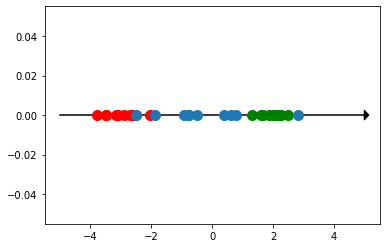

In [300]:
xs = np.linspace(-5, 5, 30)
ys = np.zeros_like(xs)
plt.plot(xs, ys, 'k')

ax = plt.axes()
ax.arrow(4.99, 0, 0.01, 0, head_width=0.005, head_length=0.15, fc='k', ec='k')

plt.plot(neg, y, 'or', markersize=10);

plt.plot(pos, y, 'og', markersize=10);

plt.plot(neutr, y, 'o', markersize=10);

### Эксперимент 1

In [147]:
df_rez_exp1['y'] = [0 for el in range(len(df_rez_exp1))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


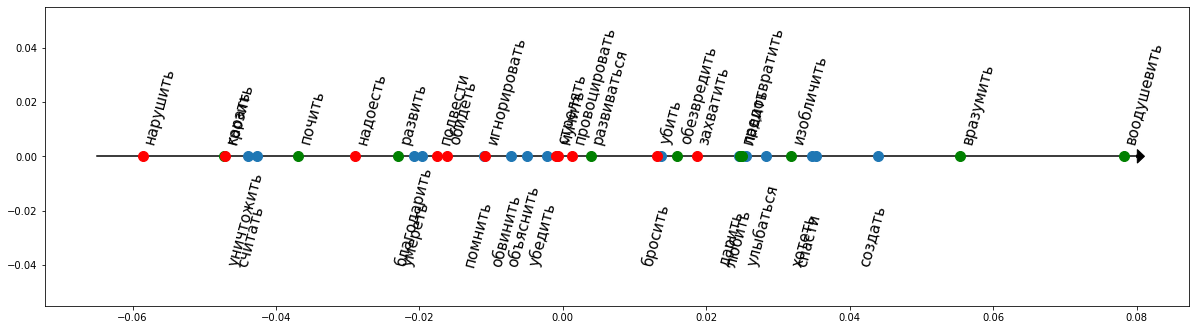

In [262]:
xs = np.linspace(-0.065, 0.08, 30)
ys = np.zeros_like(xs)
plt.plot(xs, ys, 'k')

ax = plt.axes()
ax.arrow(0.08, 0, 0.0001, 0, head_width=0.005, head_length=0.001, fc='k', ec='k')


x_neutr = df_rez_exp1[df_rez_exp1['label'] == 'neutr'].value.values.tolist()
y_neutr = [0 for _ in x_neutr]

plt.plot(x_neutr, y_neutr, 'o', markersize=10);

ax = plt.gca()
df_rez_exp1[df_rez_exp1['label'] == 'neutr'].apply(lambda x: ax.annotate(x['verb'], (x['value'] - 0.003, x['y']+ - 0.04), rotation=75, size=15), axis=1)



x_pos = df_rez_exp1[df_rez_exp1['label'] == 'pos'].value.values.tolist()
y_pos = [0 for _ in x_pos]

plt.plot(x_pos, y_pos, 'og', markersize=10);

ax = plt.gca()
df_rez_exp1[df_rez_exp1['label'] == 'pos'].apply(lambda x: ax.annotate(x['verb'], (x['value'], x['y']+ + 0.005), rotation=75, size=15), axis=1)


x_neg = df_rez_exp1[df_rez_exp1['label'] == 'neg'].value.values.tolist()
y_neg = [0 for _ in x_neg]

plt.plot(x_neg, y_neg, 'or', markersize=10);

ax = plt.gca()
df_rez_exp1[df_rez_exp1['label'] == 'neg'].apply(lambda x: ax.annotate(x['verb'], (x['value'], x['y']+ + 0.005), rotation=75, size=15), axis=1)



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20.5, 5.5)


### Эксперимент 2

In [252]:
df_rez_exp2['y'] = [0 for el in range(len(df_rez_exp2))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


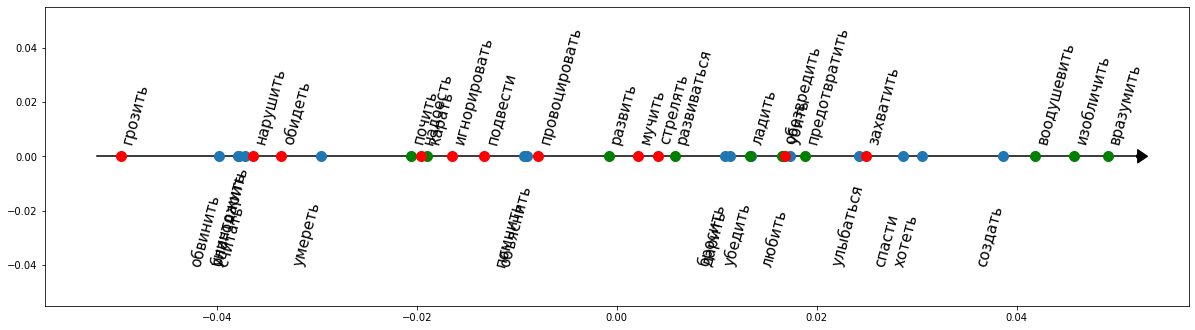

In [261]:
xs = np.linspace(-0.052, 0.052, 30)
ys = np.zeros_like(xs)
plt.plot(xs, ys, 'k')

ax = plt.axes()
ax.arrow(0.052, 0, 0.0001, 0, head_width=0.005, head_length=0.001, fc='k', ec='k')


x_neutr = df_rez_exp2[df_rez_exp2['label'] == 'neutr'].value.values.tolist()
y_neutr = [0 for _ in x_neutr]

plt.plot(x_neutr, y_neutr, 'o', markersize=10);

ax = plt.gca()
df_rez_exp2[df_rez_exp2['label'] == 'neutr'].apply(lambda x: ax.annotate(x['verb'], (x['value'] - 0.003, x['y']+ - 0.04), rotation=75, size=15), axis=1)



x_pos = df_rez_exp2[df_rez_exp2['label'] == 'pos'].value.values.tolist()
y_pos = [0 for _ in x_pos]

plt.plot(x_pos, y_pos, 'og', markersize=10);

ax = plt.gca()
df_rez_exp2[df_rez_exp2['label'] == 'pos'].apply(lambda x: ax.annotate(x['verb'], (x['value'], x['y']+ + 0.005), rotation=75, size=15), axis=1)


x_neg = df_rez_exp2[df_rez_exp2['label'] == 'neg'].value.values.tolist()
y_neg = [0 for _ in x_neg]

plt.plot(x_neg, y_neg, 'or', markersize=10);

ax = plt.gca()
df_rez_exp2[df_rez_exp2['label'] == 'neg'].apply(lambda x: ax.annotate(x['verb'], (x['value'], x['y']+ + 0.005), rotation=75, size=15), axis=1)



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20.5, 5.5)